# Using Decision Curve Analysis to make more informed decisions based on medical benefit
*Paul Hiemstra, p.h.hiemstra@windesheim.nl*

To evaluate the performance of a model, we often use simple performance metrics such as accuracy, precision, recall, and F1 score. While these metrics are useful, they do not provide a complete picture of the model's performance. 

For example, a model with high accuracy may not be useful if it has a high false negative rate, which means it is missing important cases. Similarly, a model with high precision may not be useful if it has a low recall, which means it is not identifying all relevant cases. 

To get a more complete picture of a model's performance, we need to go beyond simple performance metrics and use decision curve analysis (DCA). DCA is a method for evaluating the clinical utility of a model by comparing its net benefit to that of other strategies, such as treating all patients or treating none. 

DCA takes into account the consequences of false positives and false negatives, as well as the costs and benefits of different treatment strategies. By using DCA, we can identify the range of threshold probabilities at which a model is clinically useful and make more informed decisions about how to use the model in practice.

Heavily inspried by [this tutorial](https://mskcc-epi-bio.github.io/decisioncurveanalysis/dca-tutorial-python.html). 

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In this tutorial we use the example of cancer screening. In general, if cancer is caught early it is much more likely to be treatable. The only way to be 100 percent certain is to perform a biopsy, but this is not without risk and can be quite painful. So, we have a medical challenge here: how do we choose which people to biopsy where we balance the risk of unnecessary biopsies versus the risk of not catching cancer early enough. We have a dataset of 750 patients, based on which we will evaluate a number of biopsy strategies: 

- Biopsy no one
- Biopsy everyone
- Biopsy only people that show a high risk based on a statistical model 

We start by loading our dataset of 750 patients:

In [13]:
df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')
df_cancer_dx.head()

,patientid,cancer,risk_group,age,famhistory,marker,cancerpredmarker
0,1,0,low,64.03445,0,0.776309,0.037201
1,2,0,high,78.46741,0,0.267086,0.578907
2,3,0,low,64.14617,0,0.169621,0.021551
3,4,0,low,58.53482,0,0.023996,0.003910
4,5,0,low,63.99250,0,0.070910,0.018790


With the following columns:

- `patientid`: unique id of the patient
- `cancer`: binary indicator of whether the patient has been diagnosed with cancer (1) or not (0).
- `risk_group`: the risk of the patient actually having cancer: low medium high.
- `age`: age of the patient.
- `famhistory`: binary indicator of whether the patient has a family history of cancer (1) or not (0).
- `marker`: a specific biological marker related to cancer. Value indicates the presence of this marker. 
- `cancerpredmarker`: log-odds generated by a model to predict the likelihood of the patient having cancer

To explore the data more thoroughly, we create some histograms of the relevant columns. Note we skip the `patientid` column as it does not have a signicant meaning, and `cancerpredmarker` as this is the outcome of a model we will reproduce. 

array([[<Axes: title={'center': 'cancer'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'famhistory'}>,
        <Axes: title={'center': 'marker'}>]], dtype=object)

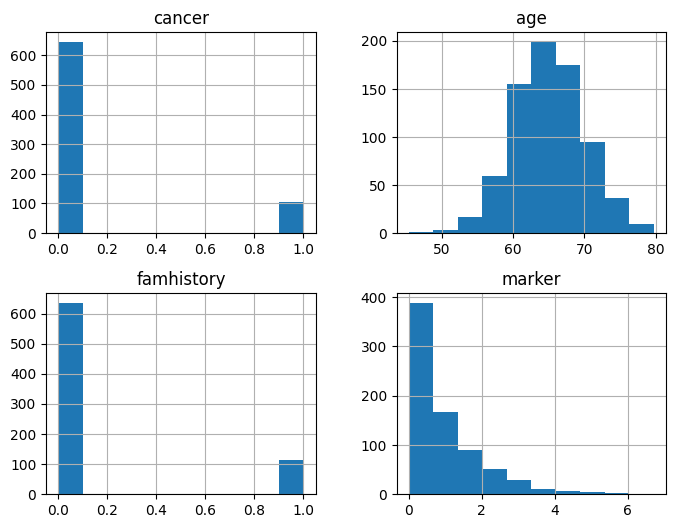

In [31]:
df_cancer_dx = df_cancer_dx.drop(columns=["patientid", "cancerpredmarker"])
df_cancer_dx.hist(figsize=(8, 6))

Some observations:

- It is immediately obivous that `cancer` and `famhistory` are indeed binary variables that are unbalanced towards `0`, i.e. no cancer or no family history of cancer respectively. 
- `Age` shows a roughly normal distributions, with a mean value of around 65 yo. This makes sense because cancer is much more prevalent for older people. 
- `Marker` show a log-normal like distribution which is skewed towards 0. This makes sense as the marker is supposedly associated with cancer, and a lot more people have no cancer. 

Now we will explore two models that try and predict whether or not a patient has cancer, and thus could be used to determine which people whould be biopsied. 

# Simple famhistory model
Having a family history of cancer increases the chance that you yourself will have cancer. If we look in the data this is supported:

In [59]:
df_cancer_dx[['famhistory', 'cancer']].groupby('famhistory').agg(np.mean)

,cancer
famhistory,
0,0.127559
1,0.208696


the proportion of people with cancer that have *no* family history is around 12.8 percent, whilst  people *with* family history show a higher percentage of 20.9 percent. 

Could we exploit this trend to more accurately determine which people would have a higher chance of cancer, and thus need a biopsy? The following logistical regression fits a model `cancer ~ famhistory` based on the data we have, which can be used for new people to estimate if they need a biopsy:

In [15]:
mod1 = sm.GLM.from_formula('cancer ~ famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod1_results = mod1.fit()

print(mod1_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  750
Model:                            GLM   Df Residuals:                      748
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -301.30
Date:                Wed, 29 Nov 2023   Deviance:                       602.60
Time:                        11:01:11   Pearson chi2:                     750.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.006445
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9227      0.119    -16.163      0.0

For these kinds of logistical regressions, the coeficients of the model are easier to interpret when converting them to odds:

In [16]:
np.exp(mod1_results.params)

Intercept     0.146209
famhistory    1.803826
dtype: float64

The intercept here matches the prevalence of cancer in the dataset, so without a history of cancer your odds are 14.6 percent that you will have cancer. If you have a family history, your chances are 1.8 times bigger you will have cancer. In addition, both the coefficients show a `z` value below 0.025, so they are deemed statistically significant. So far, family history seems to be a relevant variable to take into consideration when deciding on prescribing a biopsy or not. 

### The decision curve
But what is the exact medical benefit for each of the biopsy strategies? It seems that family history is relevant, so we should probably use that? Let's make the medical benefit explicit. We use the definition of net medical benefit posited by [Vickers et al (2019)](https://diagnprognres.biomedcentral.com/articles/10.1186/s41512-019-0064-7):

In [ ]:
def net_benefit(sensitivity, specificity, prevalence, threshold):
    return (sensitivity * prevalence) - ((1 - specificity) * (1 - prevalence)) * (threshold / (1 - threshold))

where:
- *`sensitivity`* is how good the model is at detecting cancer. This means there are just a few times that cancer is missed (False Negative). 
- *`specificity`* is how good the model is at detecting a healthy person. This means there are just a few times that a patient is given an unnecessary biopsy (False Positive). 
- *`prevalence`* is how often cancer is present in the dataset. 
- *`threshold`* is the amount of risk we are willing to take in terms of cancer. A threshold of 0.10 means that if we are 10 percent sure of cancer or higher, we will order a biopsy. 
- *`sensitivity` \* prevalence* is the estimated proportion of True Positives, this is the good outcome we want and thus a plus to net benefit. 
- *`(1 - specificity) * (1 - prevalence)`* is the estimated amount of False Positives, i.e. the amount of unecessary biopsies. 
- *`threshold / (1 - threshold)`* is where we transform the risk to odds. For our 10% this translates to a 1:9 odds, meaning that for each additional cancer patient we catch (True Positive), we are willing to accept 9 biopsies on health people (False Positive). 

So we measure the positive outcome we want, and subtract the negative outcome. In addition, via the threshold we can determine how much more important we judge False Negatives versus False Positives. In the case of a threshold of 0.10, False Negatives are 9 times more important than False Negatives. 

We can calculate the net benefit of our famhistory model by calculating all the relevant inputs:

In [85]:
from sklearn.metrics import recall_score

threshold = 0.1
prevalence_data = df_cancer_dx['cancer'].sum() / len(df_cancer_dx['cancer'])
cancer_pred_famhistory = df_cancer_dx['famhistory'] > threshold
sensitivity = recall_score(df_cancer_dx['cancer'], cancer_pred_famhistory)
specificity = recall_score(np.logical_not(df_cancer_dx['cancer']), np.logical_not(cancer_pred_famhistory))
net_benefit(sensitivity, specificity, prevalence_data, threshold)

0.018518518518518517

Important to note here that the prediction if a person needs a biopsy or not is *not* based on the probablity output of `mod1_results`. This mirrors what happens if family history would be used in medical practice: if the patient has a family history we order a biopsy, if not we do not order the biopsy. Alternatively, we could take the probablity from the logistical regression and compare this to the threshold, but this is not typically done in these kinds of analyses. 

Using family history yields a positive net benefit, but how does this relate to another viable strategy: just biopsy everyone? The key change here is the `cancer_pred` variable:

In [86]:
cancer_pred_always = np.ones(len(df_cancer_dx['cancer'])) > threshold    # This is always True, in line with the strategy
sensitivity = recall_score(df_cancer_dx['cancer'], cancer_pred_always)
specificity = recall_score(np.logical_not(df_cancer_dx['cancer']), np.logical_not(cancer_pred_always))
net_benefit(sensitivity, specificity, prevalence_data, threshold)

0.04444444444444445

Which shows a much higher net benefit. So, for a risk threshold of 10% the best strategy is not to use family history but to just biopsy everyone. 

But how does this net benefit vary across a range of threshold values? The following code calculates this:

<Axes: >

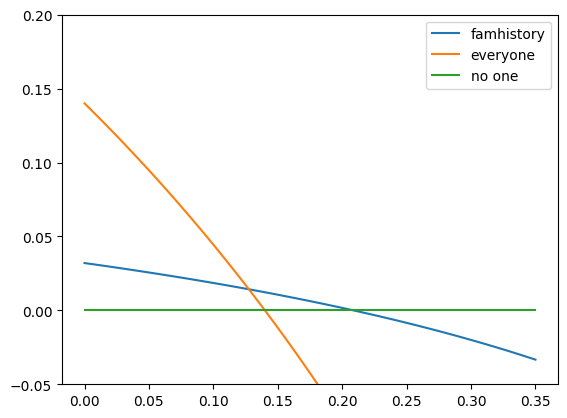

In [106]:
e = 1e-6   # needed because 0 or 1 does not lead to correct TP/FP values
thold = np.linspace(0 + e, 0.35, 100)   # The thresholds we are interested in
prevalence_cancer = df_cancer_dx['cancer'].sum() / len(df_cancer_dx['cancer'])  

# helper function to get sensitivity and specificity for a given prediction
# Note that I only pass the required variables, the others are taken from the global environment.
# This means these helper functions are not self-contained, and this approach should generally not be used, 
# but it makes the code more readable for this example, where understanding the code is more important than reusability.
def get_sensitivity_specificity(pred):
    sensitivity = recall_score(df_cancer_dx['cancer'], pred)
    specificity = recall_score(np.logical_not(df_cancer_dx['cancer']), np.logical_not(pred))
    return sensitivity, specificity

# Helper function to calculate net benefit for a given input vector of prediction probabilities
def calc_net_benefit(input_prob):
    sensitivity, specificity = zip(*[get_sensitivity_specificity((input_prob >= prob).astype(int)) for prob in thold])
    return net_benefit(np.array(sensitivity), np.array(specificity), prevalence_cancer, thold)

# Calculate net benefit for all options
result = pd.DataFrame(index=thold)
result['famhistory'] = calc_net_benefit(df_cancer_dx['famhistory'])
result['everyone']   = calc_net_benefit(np.ones(len(df_cancer_dx['cancer'])))     # All ones, so always predict biopsy
result['no one']     = calc_net_benefit(np.zeros(len(df_cancer_dx['cancer'])))    # All zeros, so never predict biopsy

result.plot(ylim=(-0.05, 0.2))

which paints an even bleaker picture for our family history model: when we place more emphasis on preventing biopsies, almost always (`>= 0.22`) it is better to biopsy no one. In addition, when we value True Positives more highly (`<=0.13`) the better strategy is to biopsy everyone. In just a very narrow threshold window (0.13-0.22) the family history has a small added benefit. 

So, if my doctor thinks it 10 percent likely 

Note that this graph can be reproduced more easily using the `dcurves` package:

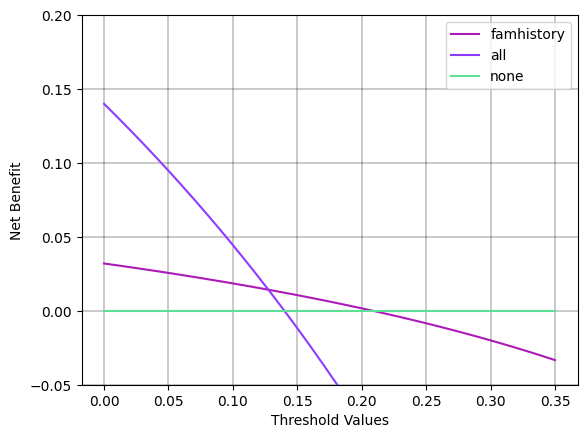

In [69]:
from dcurves import dca, plot_graphs

dca_famhistory_df = dca(data=df_cancer_dx, outcome='cancer', modelnames=['famhistory'], thresholds=np.arange(0, 0.36, 0.01))
plot_graphs(plot_df=dca_famhistory_df, graph_type='net_benefit', y_limits=[-0.05, 0.2],)

But we have more data available on which we could base our decision to biopsy or not, so we could build a more complex model in an attempt to make more informed biopsy decisions. 

# Building and evaluating a more complex model
Apart from family history, we also have:

- `marker` a genetic marker that is thought to be associated with the presence of cancer
- `age` where older people have a higher chance of cancer

Let's explore the data and see what this tells us:

array([<Axes: title={'center': 'age'}, xlabel='[cancer]'>,
       <Axes: title={'center': 'marker'}, xlabel='[cancer]'>],
      dtype=object)

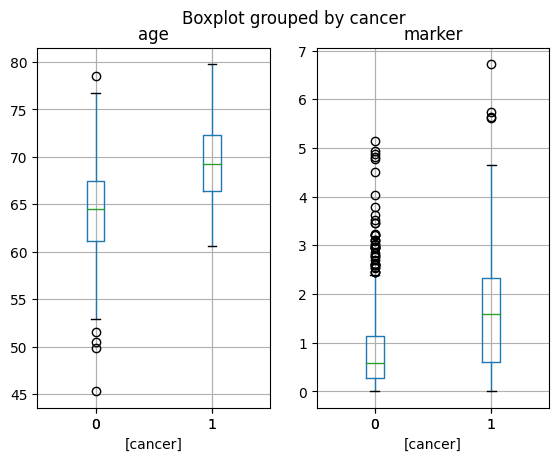

In [91]:
df_cancer_dx[['cancer', 'marker', 'age']].boxplot(by='cancer', sharey=False)

There is a definite relation between both age and marker and the occurence of cancer: the core of the boxes for `cancer == 1` show higher values. But especially the marker shows a lot of outliers where a high marker is not associated with cancer. 

Lets first try and add the marker to our model and see how this impacts net_benefit:

<Axes: >

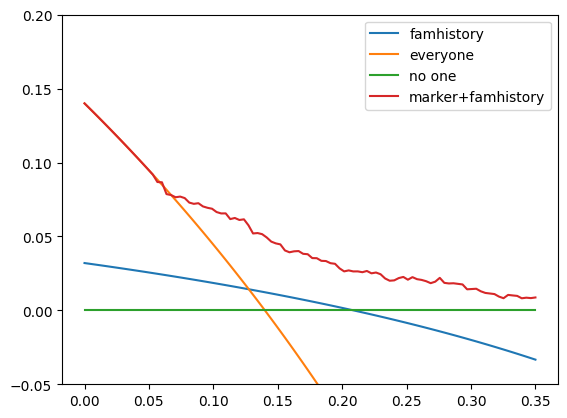

In [107]:
mod2 = sm.GLM.from_formula('cancer ~ marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod2_results = mod2.fit()

result['marker+famhistory'] = calc_net_benefit(mod2_results.predict(df_cancer_dx))
result.plot(ylim=(-0.05, 0.2))

This defnitely improves our net_benefit, which is higher than the biopsy everyone option above a risk threshold of 0.06. Will adding `age` to our model improve it even further?

If we look at the interaction between marker, age and cancer:

<Axes: xlabel='marker', ylabel='age'>

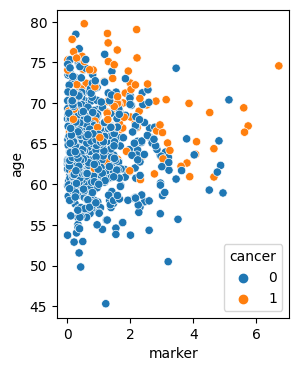

In [98]:
sb.scatterplot(data=df_cancer_dx, x='marker', y='age', hue='cancer', figure=plt.figure(figsize=(3, 4)))

This builds a clearer picture of what is happening:
- For younger people (`age < 60`), the marker is not influential: no one has cancer
- For older people (`age > 75`), the marker has little influence: many people have cancer
- In the range in between the marker shows a lot more predictive power as in that age range the marker is associated with more likelyhood of cancer.

So, age and marker in itself have predictive power, but combining them together makes a lot of sense. The following code builds a joint model:

<Axes: >

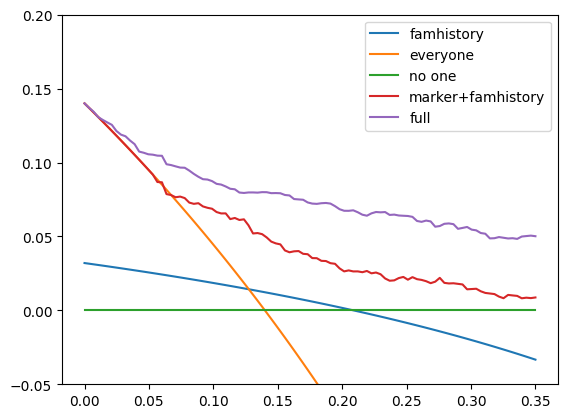

In [108]:
mod3 = sm.GLM.from_formula('cancer ~ age + marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod3_results = mod3.fit()

result['full'] = calc_net_benefit(mod3_results.predict(df_cancer_dx))
result.plot(ylim=(-0.05, 0.2))

Which increases the net_benefit quite a bit, only at a threshold below 2 percent the option to biopsy everyone is better. Therefore, the complex model has the most clinical benefit and should be used in practice almost all of the time. Only when the threshold is 2 percent, i.e. we accept 49 uneccessary biopsies for each True Positive cancer patient, just biopsying everyone is a better strategy. 

The following code reproduces the entire analysis. Plotting the decision curve using `dcurves` is probably the way to go, but this example code much more transparently shows what is happening. 

<Axes: >

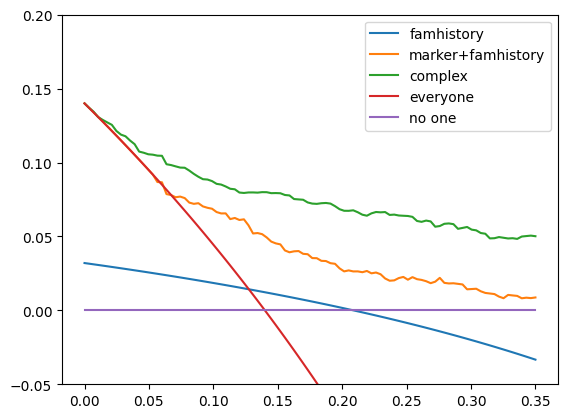

In [111]:
from sklearn.metrics import recall_score
import pandas as pd
import numpy as np
import statsmodels.api as sm

def net_benefit(sensitivity, specificity, prevalence, threshold):
    return (sensitivity * prevalence) - ((1 - specificity) * (1 - prevalence)) * (threshold / (1 - threshold))

df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')

# Simple model with only family history
mod1 = sm.GLM.from_formula('cancer ~ famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod1_results = mod1.fit()

# More complex model with family history, age, and marker
mod2 = sm.GLM.from_formula('cancer ~ marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod2_results = mod2.fit()

mod3 = sm.GLM.from_formula('cancer ~ age + marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod3_results = mod3.fit()

e = 1e-6   # needed because 0 or 1 does not lead to correct TP/FP values
thold = np.linspace(0 + e, 0.35, 100)
true = df_cancer_dx['cancer']
prevalence_cancer = df_cancer_dx['cancer'].sum() / len(df_cancer_dx['cancer'])  

# helper function to get sensitivity and specificity for a given prediction
def get_sensitivity_specificity(pred):
    sensitivity = recall_score(true, pred)
    specificity = recall_score(np.logical_not(true), np.logical_not(pred))
    return sensitivity, specificity

# Helper function to calculate net benefit for a given input vector of prediction probabilities
def calc_net_benefit(input_prob):
    sensitivity, specificity = zip(*[get_sensitivity_specificity((input_prob >= prob).astype(int)) for prob in thold])
    return net_benefit(np.array(sensitivity), np.array(specificity), prevalence_cancer, thold)

# Calculate net benefit for all options
result = pd.DataFrame(index=thold)
result['famhistory']        = calc_net_benefit(df_cancer_dx['famhistory'])
result['marker+famhistory'] = calc_net_benefit(mod2_results.predict())
result['complex']           = calc_net_benefit(mod3_results.predict())
result['everyone']          = calc_net_benefit(np.ones(len(df_cancer_dx['cancer'])))
result['no one']            = calc_net_benefit(np.zeros(len(df_cancer_dx['cancer'])))

result.plot(ylim=(-0.05, 0.2))

# Appendix 1: train-test split and other metrics
The tutorial above calculates the metrics on exactly the same data as the fitted model. Because the model is trained and tested on the same data, it is vulnerable to overfitting. We can fix this using train-test-split, or crossvalidation. In addition we want to compare net_benefit to other metrics, and see how they compare. 

In [117]:
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import statsmodels.api as sm

def net_benefit(sensitivity, specificity, prevalence, threshold):
    return (sensitivity * prevalence) - ((1 - specificity) * (1 - prevalence)) * (threshold / (1 - threshold))

df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')
df_cancer_train, df_cancer_test = train_test_split(df_cancer_dx, test_size=0.3, stratify=df_cancer_dx['cancer'])

In [118]:
print(df_cancer_train['cancer'].sum() / len(df_cancer_train['cancer']))
print(df_cancer_test['cancer'].sum() / len(df_cancer_test['cancer']))

0.14095238095238094
0.13777777777777778


In [1]:
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import train_test_split
from itertools import product
import pandas as pd
import numpy as np
import statsmodels.api as sm

def net_benefit(sensitivity, specificity, prevalence, threshold):
    return (sensitivity * prevalence) - ((1 - specificity) * (1 - prevalence)) * (threshold / (1 - threshold))

# helper function to get sensitivity and specificity for a given prediction
def get_sensitivity_specificity(pred):
    sensitivity = recall_score(true, pred)
    specificity = recall_score(np.logical_not(true), np.logical_not(pred))
    return sensitivity, specificity

# Helper function to calculate net benefit for a given input vector of prediction probabilities
def calc_net_benefit(input_prob):
    sensitivity, specificity = zip(*[get_sensitivity_specificity((input_prob >= prob).astype(int)) for prob in thold])
    return net_benefit(np.array(sensitivity), np.array(specificity), prevalence_cancer, thold)

def calc_accuracy(input_prob):
    return [((input_prob >= prob).astype(int) == true).sum() / len(input_prob) for prob in thold]

def calc_f1(input_prob):
    return [f1_score(true, (input_prob >= prob).astype(int), pos_label=1) for prob in thold]

def calc_metrics(input_prob, metrics):
    metric_data = pd.DataFrame([m(ip) for ip, m in product(input_prob.values(), metrics.values())]).T
    metric_data.columns = [colname + '_' + postifx for postifx, colname in product(input_prob.keys(), metrics.keys())]
    metric_data.index = thold
    return metric_data

df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')
df_cancer_train, df_cancer_test = train_test_split(df_cancer_dx, test_size=0.3, stratify=df_cancer_dx['cancer'])

# Simple model with only family history
mod1 = sm.GLM.from_formula('cancer ~ famhistory', data=df_cancer_train, family=sm.families.Binomial())
mod1_results = mod1.fit()

# More complex model with family history, age, and marker
mod2 = sm.GLM.from_formula('cancer ~ marker + famhistory', data=df_cancer_train, family=sm.families.Binomial())
mod2_results = mod2.fit()

mod3 = sm.GLM.from_formula('cancer ~ age + marker + famhistory', data=df_cancer_train, family=sm.families.Binomial())
mod3_results = mod3.fit()

e = 1e-6   # needed because 0 or 1 does not lead to correct TP/FP values
thold = np.linspace(0 + e, 0.35, 100)
true = df_cancer_test['cancer']
prevalence_cancer = df_cancer_test['cancer'].sum() / len(df_cancer_test['cancer'])  

# Calculate net benefit for all options
result = calc_metrics({'famhistory':        df_cancer_test['famhistory'],
                       'marker+famhistory': mod2_results.predict(df_cancer_test),
                       'complex':           mod3_results.predict(df_cancer_test),
                       'everyone':          np.ones(len(df_cancer_test['cancer'])),
                       'no one':            np.zeros(len(df_cancer_test['cancer']))}, 
                      {'net_benefit': calc_net_benefit, 'accuracy': calc_accuracy, 'f1_score': calc_f1})

<Axes: >

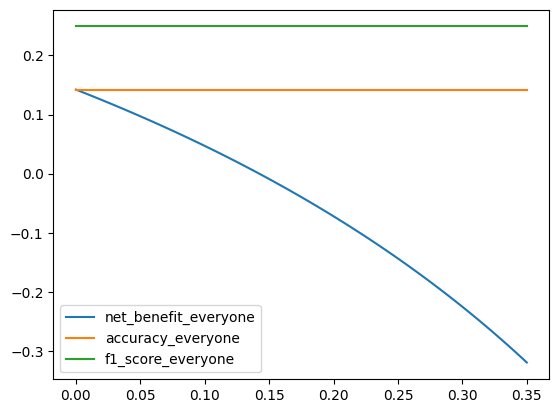

In [2]:
result = calc_metrics({'everyone':          np.ones(len(df_cancer_test['cancer']))},
                      {'net_benefit': calc_net_benefit, 'accuracy': calc_accuracy, 'f1_score': calc_f1})
result.plot()

<Axes: >

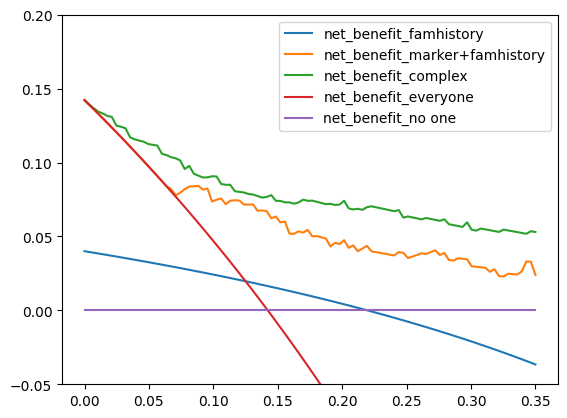

In [5]:
result.filter(regex='net_benefit').plot(ylim=(-0.05, 0.2))

<Axes: >

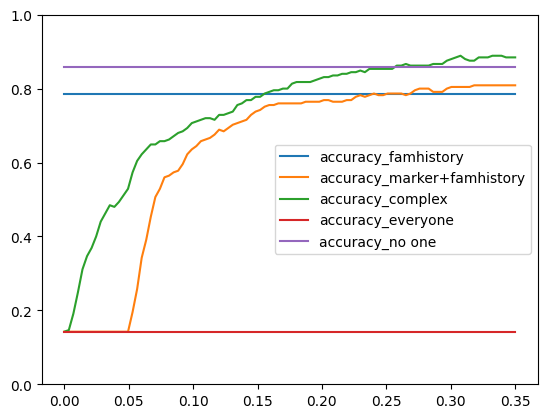

In [17]:
result.filter(regex='accuracy').plot(ylim=(0, 1))

<Axes: >

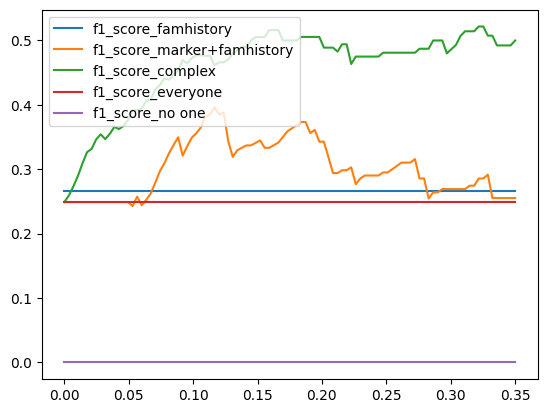

In [9]:
result.filter(regex='f1_score').plot()

In [166]:
from itertools import product

input_prob = [df_cancer_test['famhistory'], mod3_results.predict(df_cancer_test)]
metrics = [calc_net_benefit, calc_accuracy]

pd.DataFrame([m(ip) for ip, m in list(product(*[input_prob, metrics]))]).T

,0,1,2,3
0,0.035555,0.768889,0.137777,0.137778
1,0.035098,0.768889,0.134781,0.155556
2,0.034638,0.768889,0.131859,0.168889
3,0.034174,0.768889,0.129630,0.240000
4,0.033707,0.768889,0.123196,0.288889
...,...,...,...,...
95,-0.029624,0.768889,0.055327,0.897778
96,-0.030663,0.768889,0.055005,0.897778
97,-0.031712,0.768889,0.054679,0.897778
98,-0.032773,0.768889,0.054350,0.897778


In [150]:
col_postfix = 'famhistory'
cols = ['net_benefit', 'accuracy']
list(zip(cols, [col_postfix] * len(cols)))


[('net_benefit', 'famhistory'), ('accuracy', 'famhistory')]